## Ataques de tiburones:
Vamos a determinar el número de ataques distribuidos por decada a partir del año 1900 y contabilizando el tipo de ataques
y si estos han sido fatales.
Ver que meses son los más peligrosos y sexo etc


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

**Se ha de añadir la codificación para obtener los datos correctamente del csv. (ISO-8859-1)**

In [2]:
data = pd.read_csv('./data/GSAF5.csv', encoding='ISO-8859-1')
data.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


# Limpieza de datos
Consultamos la información del dataframe, para ver los nombre de las columnas y los tipos de datos

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 24 columns):
Case Number               5992 non-null object
Date                      5992 non-null object
Year                      5992 non-null int64
Type                      5992 non-null object
Country                   5949 non-null object
Area                      5590 non-null object
Location                  5496 non-null object
Activity                  5465 non-null object
Name                      5792 non-null object
Sex                       5425 non-null object
Age                       3311 non-null object
Injury                    5965 non-null object
Fatal (Y/N)               5973 non-null object
Time                      2779 non-null object
Species                   3058 non-null object
Investigator or Source    5977 non-null object
pdf                       5992 non-null object
href formula              5991 non-null object
href                      5989 non-null object
C

**Análisis de los valores nulos para decidir que columnas eliminar**

In [4]:
#He creado una función para poder reutilizarla posteriormente
def nulos(dataframe):
    null_cols = dataframe.isnull().sum()
    print(null_cols[null_cols > 0])
    return null_cols

null_cols = nulos(data)

Country                     43
Area                       402
Location                   496
Activity                   527
Name                       200
Sex                        567
Age                       2681
Injury                      27
Fatal (Y/N)                 19
Time                      3213
Species                   2934
Investigator or Source      15
href formula                 1
href                         3
Unnamed: 22               5991
Unnamed: 23               5990
dtype: int64


**Eliminación de las columnas con demasiados nulos y las que no vamos a utilizar en el análisis**

In [5]:
#Eliminio las columnas que tienen más de 3000 registros nulos ya que son más del 50% de los registros  
drop_cols = list(null_cols[null_cols > 3000].index)
nueva_data = data.drop(drop_cols, axis=1)


In [6]:
#También eliminio otras columnas que no voy a utilizar
nueva_data = nueva_data.drop(['Area', 'Location', 'Species ', 'Injury', 'Age', 'Activity', 'Name', 'Date', 'Investigator or Source', 'pdf', 'href formula', 'href', 'Case Number.1', 'Case Number.2', 'original order'], axis=1)
display(nueva_data.head())
print(nueva_data.shape)

,Case Number,Year,Type,Country,Sex,Fatal (Y/N)
0,2016.09.18.c,2016,Unprovoked,USA,M,N
1,2016.09.18.b,2016,Unprovoked,USA,M,N
2,2016.09.18.a,2016,Unprovoked,USA,M,N
3,2016.09.17,2016,Unprovoked,AUSTRALIA,M,N
4,2016.09.15,2016,Unprovoked,AUSTRALIA,M,N


(5992, 6)


In [7]:
#Realizo una primera comprobación de registros duplicados
def remover_duplicados(dataframe, columnas = []):
    antes = len(dataframe)
    dataframe = dataframe[columnas].drop_duplicates()
    despues = len(dataframe)
    total = antes - despues
    print('Registros duplicados eliminados: {}'.format(total))
    return dataframe

remover_duplicados(data)

Registros duplicados eliminados: 0


""
0
1
2
3
4
5
6
7
8
9


In [8]:
test = nueva_data[(nueva_data['Year'] == 0)] #valores incorrectos
print(len(test))

124


In [9]:
#Low variance y Valores extremos
low_variance = []

for col in nueva_data._get_numeric_data():
    minimum = min(nueva_data[col])
    ninety_perc = np.percentile(nueva_data[col], 90)
    if ninety_perc == minimum:
        low_variance.append(col)

print('Low Variance', low_variance)

stats = nueva_data.describe().transpose()
stats['IQR'] = stats['75%'] - stats['25%']
stats

Low Variance []


,count,mean,std,min,25%,50%,75%,max,IQR
Year,5992.0,1925.204606,286.473712,0.0,1942.0,1975.0,2003.0,2016.0,61.0


In [11]:
outliers = pd.DataFrame(columns=nueva_data.columns)

for col in stats.index:
    iqr = stats.at[col,'IQR']
    cutoff = iqr * 1.5
    lower = stats.at[col,'25%'] - cutoff
    upper = stats.at[col,'75%'] + cutoff
    results = nueva_data[(nueva_data[col] < lower) | 
                   (nueva_data[col] > upper)].copy()
    results['Outlier'] = col
    outliers = outliers.append(results)

print(len(outliers))

238


**Estas son las columnas que mantendremos para el análisis**

In [12]:
#Columnas restantes
print(nueva_data.columns)
print(len(nueva_data.columns))

Index(['Case Number', 'Year', 'Type', 'Country', 'Sex ', 'Fatal (Y/N)'], dtype='object')
6


In [13]:
#Renombro varias columnas, unas porque tienen un espacio al final y otras porque contienen otros caracteres
nueva_data = nueva_data.rename(columns={'Fatal (Y/N)':'Fatal', 
                                  'Sex ':'Sex'})
print(nueva_data.columns)
print(nueva_data.shape)

Index(['Case Number', 'Year', 'Type', 'Country', 'Sex', 'Fatal'], dtype='object')
(5992, 6)


In [14]:
#Compruebo los diferentes tipos de ataque y los difrentes valores para la columan Fatal
tipos_ataque = nueva_data.Type.unique()
print(tipos_ataque)
set(nueva_data['Type'])

nueva_data['Fatal'].value_counts()


['Unprovoked' 'Boat' 'Provoked' 'Invalid' 'Sea Disaster' 'Boating']


N          4315
Y          1552
UNKNOWN      94
 N            8
N             1
F             1
n             1
#VALUE!       1
Name: Fatal, dtype: int64

In [15]:
#Para la columna Country asignamos el valor "Otro" a los valores nulos
nueva_data['Country'] = nueva_data['Country'].str.strip().str.upper()
nueva_data['Country'] = nueva_data['Country'].fillna('Otro')

In [16]:
print(set(nueva_data['Sex']))

# N la cambiamos por M ya que al estar la teclas tan próximas lo consideramos un error al introducir los datos
# y al ser su número reducido optamos por asignarles M

nueva_data['Sex'] = nueva_data['Sex'].str.strip().str.upper()
nueva_data['Sex'] = nueva_data['Sex'].str.replace('.', 'UNKNOWN')
nueva_data['Sex'] = nueva_data['Sex'].str.replace('N', 'M') 
nueva_data['Sex'] = nueva_data['Sex'].str.replace('LLI', 'UNKNOWN')
nueva_data['Sex'] = nueva_data['Sex'].str.replace('UMKMOWM', 'UNKNOWN')
nueva_data['Sex'] = nueva_data['Sex'].fillna('UNKNOWN')

print(set(nueva_data['Sex']))
print(nueva_data['Sex'].value_counts())

{nan, '.', 'lli', 'F', 'N', 'M ', 'M'}
{'F', 'M', 'UNKNOWN'}
M          4838
F           585
UNKNOWN     569
Name: Sex, dtype: int64


In [17]:
#Modificamos los datos en la columna Fatal para unificarlos (N, Y, UNKNOWN)
nueva_data['Fatal'] = nueva_data['Fatal'].str.strip().str.upper()
nueva_data['Fatal'] = nueva_data['Fatal'].str.replace('#VALUE!', 'UNKNOWN')
nueva_data['Fatal'] = nueva_data['Fatal'].str.replace('F', 'UNKNOWN')

#Los valores nulos también los pasamos a UNKNOWN
nueva_data['Fatal'] = nueva_data['Fatal'].fillna('UNKNOWN')
print(set(nueva_data['Fatal']))
print(nueva_data['Fatal'].value_counts())

{'N', 'UNKNOWN', 'Y'}
N          4325
Y          1552
UNKNOWN     115
Name: Fatal, dtype: int64


In [18]:
#Comprobamos los nulos en el nuevo dataframe 
nulos(nueva_data)

Series([], dtype: int64)


Case Number    0
Year           0
Type           0
Country        0
Sex            0
Fatal          0
dtype: int64

In [19]:
#Volvemos a comprobar si hay duplicados después del cambio en la columna Fatal
print(len(nueva_data))
nueva_data = remover_duplicados(nueva_data, nueva_data.columns)
print(len(nueva_data))

5992
Registros duplicados eliminados: 4
5988


# Datos sobre los que realizaremos el estudio

### Se mostrará la evolución de los ataque de tiburón en las decadas del siglo 20

<p align="center"><img src="http://pngimg.com/uploads/shark/shark_PNG18831.png" width="50%"  /></p>

In [20]:
#Se filtran los registros entres a partir de el año 1900, los datos anteriores no los tendremos en cuenta
#Para este estudio, a su vez también descartamos los ataques clasificados como Invalid.

datos = nueva_data[(nueva_data.Year > 1900) & (nueva_data.Year <= 2000) & (nueva_data.Type != 'Invalid')]
datos = datos.sort_values(by=['Year'])
datos.head()

,Case Number,Year,Type,Country,Sex,Fatal
5311,1901.00.00,1901,Unprovoked,USA,M,N
5303,1901.12.01,1901,Unprovoked,AUSTRALIA,M,N
5304,1901.10.00,1901,Unprovoked,PHILIPPINES,M,N
5310,1901.01.30,1901,Unprovoked,AUSTRALIA,M,Y
5306,1901.07.30,1901,Unprovoked,SOUTH AFRICA,M,Y


In [21]:
#Vamos a añadir una columna de mes, esta la obtendremos de la columna "Case Number"
def obtener_mes(fecha):
    n = re.findall('[^.]+[0-9]{1}', fecha)
    return n[1]
    
    
datos['Month'] = datos['Case Number'].apply(obtener_mes) 
#Reordenamos las celdas
columnas_orden = ['Year', 'Month', 'Type', 'Fatal', 'Sex', 'Country', 'Case Number']
datos = datos[columnas_orden]
datos.head()
#datos.shape

,Year,Month,Type,Fatal,Sex,Country,Case Number
5311,1901,00,Unprovoked,N,M,USA,1901.00.00
5303,1901,12,Unprovoked,N,M,AUSTRALIA,1901.12.01
5304,1901,10,Unprovoked,N,M,PHILIPPINES,1901.10.00
5310,1901,01,Unprovoked,Y,M,AUSTRALIA,1901.01.30
5306,1901,07,Unprovoked,Y,M,SOUTH AFRICA,1901.07.30


In [22]:
#Comprobamos los valores insertados en la columna Month además le cambiamos el tipo
datos['Month'] = datos['Month'].astype('int')
#datos['Month'].value_counts() / len(datos) * 100
datos['Month'].value_counts()

7     343
8     312
1     298
9     266
0     257
12    253
11    231
6     229
2     227
3     222
10    219
4     205
5     182
30      1
Name: Month, dtype: int64

In [23]:
#Como pudimos ver anteriormente hay demasiados meses con valor 0 y alguno con valor 30
#El de valor 30 lo descarto, pero los de valor 0 me planteo que hacer con ellos.
#Los cambiaré por el valor de la media

datos = datos[(datos.Month != 30)]

media_mes = datos['Month'].mean()

datos.loc[(datos['Month'] == 0 ), 'Month'] = int(media_mes)
datos.head()

,Year,Month,Type,Fatal,Sex,Country,Case Number
5311,1901,6,Unprovoked,N,M,USA,1901.00.00
5303,1901,12,Unprovoked,N,M,AUSTRALIA,1901.12.01
5304,1901,10,Unprovoked,N,M,PHILIPPINES,1901.10.00
5310,1901,1,Unprovoked,Y,M,AUSTRALIA,1901.01.30
5306,1901,7,Unprovoked,Y,M,SOUTH AFRICA,1901.07.30


In [24]:
#Creo bins para las decadas del siglo 20
decadas = ['Años 00', 'Años 10', 'Años 20', 'Años 30', 'Años 40', 
           'Años 50', 'Años 60', 'Años 70', 'Años 80', 'Años 90']
cutoffs = [1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2001]

decadas_bins = pd.cut(datos['Year'], cutoffs, labels = decadas)
decadas_bins.head()

5311    Años 00
5303    Años 00
5304    Años 00
5310    Años 00
5306    Años 00
Name: Year, dtype: category
Categories (10, object): [Años 00 < Años 10 < Años 20 < Años 30 ... Años 60 < Años 70 < Años 80 < Años 90]

## Evolución de los ataques

In [25]:
datos_siglo = datos
datos_siglo['Decade'] = decadas_bins
#datos_siglo.loc[datos_siglo['Year'] == 2000].head()
datos_siglo.head()

,Year,Month,Type,Fatal,Sex,Country,Case Number,Decade
5311,1901,6,Unprovoked,N,M,USA,1901.00.00,Años 00
5303,1901,12,Unprovoked,N,M,AUSTRALIA,1901.12.01,Años 00
5304,1901,10,Unprovoked,N,M,PHILIPPINES,1901.10.00,Años 00
5310,1901,1,Unprovoked,Y,M,AUSTRALIA,1901.01.30,Años 00
5306,1901,7,Unprovoked,Y,M,SOUTH AFRICA,1901.07.30,Años 00


In [26]:
decadas_graf = datos_siglo.Decade.value_counts().sort_index()

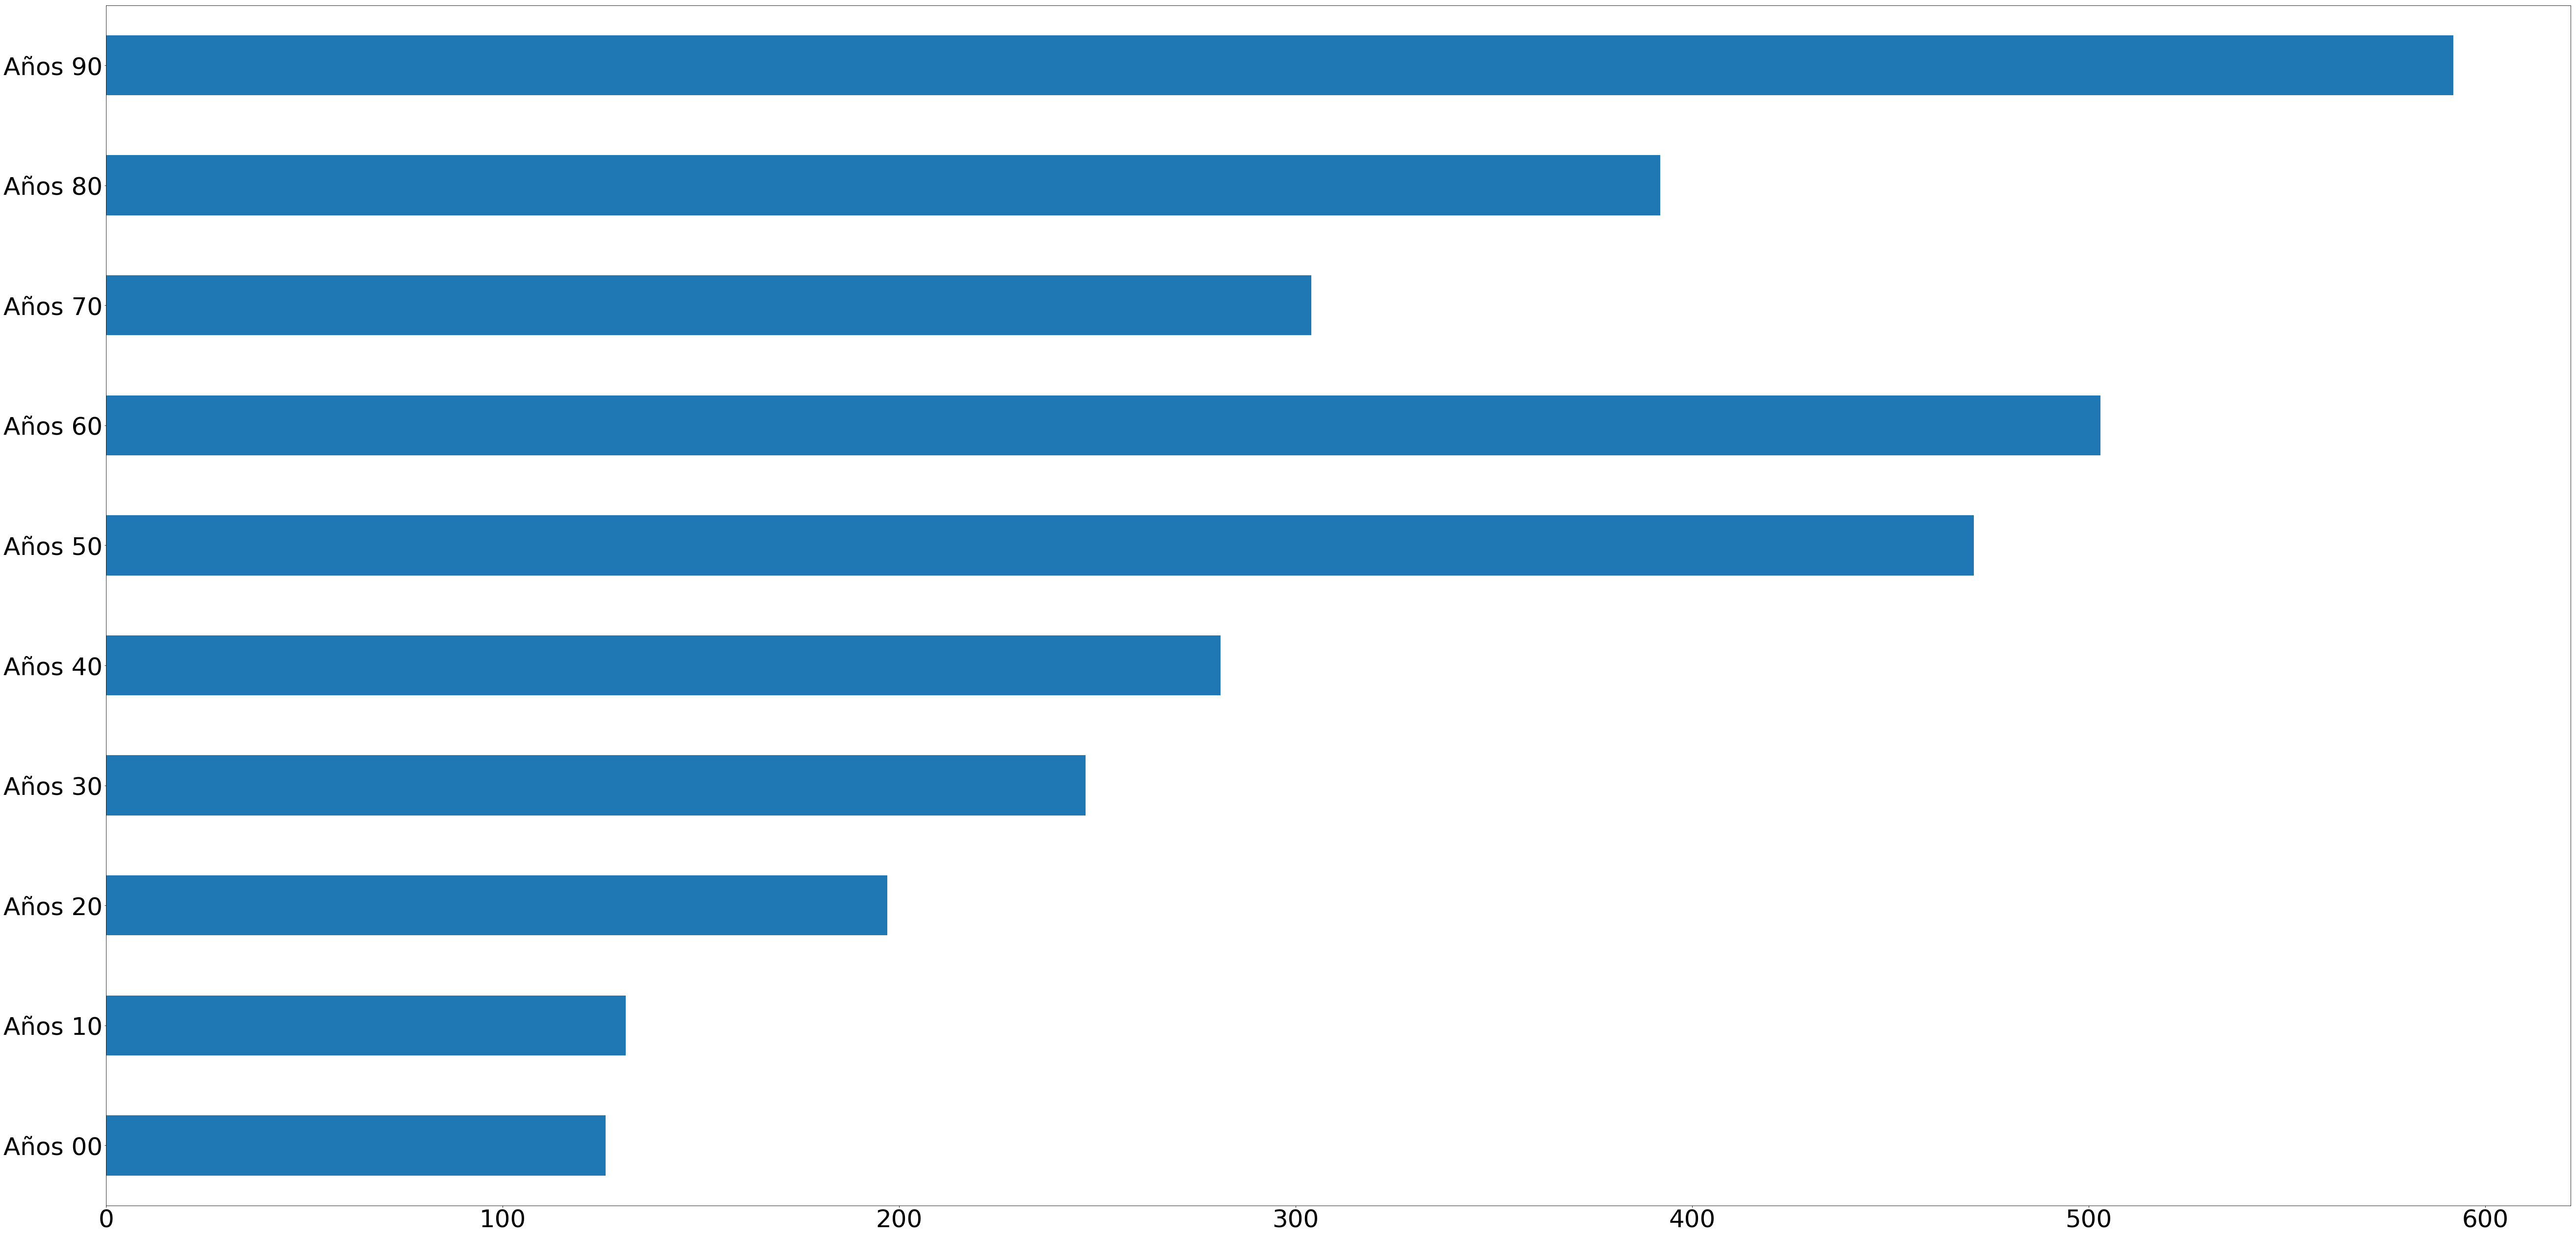

In [27]:
decadas_graf.plot(kind = 'barh', title = '', figsize = (90, 45), fontsize = 50)

In [28]:
datos_siglo.to_csv("datos-ataques-siglo20.csv", index = False)
datos_siglo.head()

,Year,Month,Type,Fatal,Sex,Country,Case Number,Decade
5311,1901,6,Unprovoked,N,M,USA,1901.00.00,Años 00
5303,1901,12,Unprovoked,N,M,AUSTRALIA,1901.12.01,Años 00
5304,1901,10,Unprovoked,N,M,PHILIPPINES,1901.10.00,Años 00
5310,1901,1,Unprovoked,Y,M,AUSTRALIA,1901.01.30,Años 00
5306,1901,7,Unprovoked,Y,M,SOUTH AFRICA,1901.07.30,Años 00


## Tipos de ataque en el siglo 20

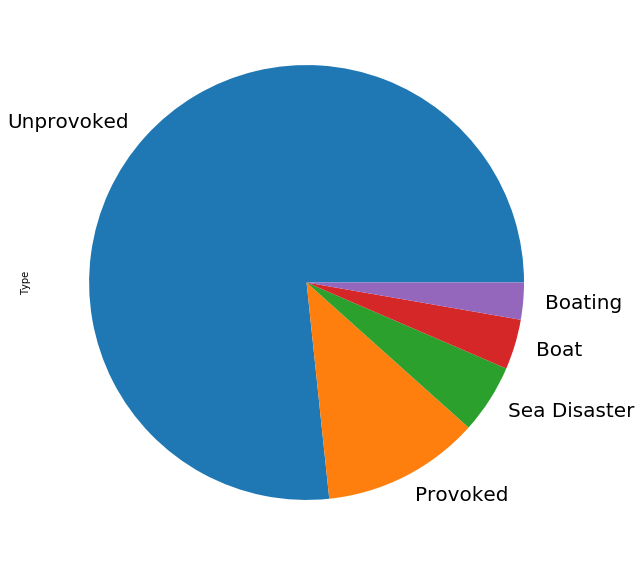

In [29]:
#Tipos de ataque
tipos_ataque = datos_siglo['Type'].value_counts()
tipos_ataque.plot.pie(title = '' , figsize = (10, 10), fontsize = 20 )

## Ataques por mes

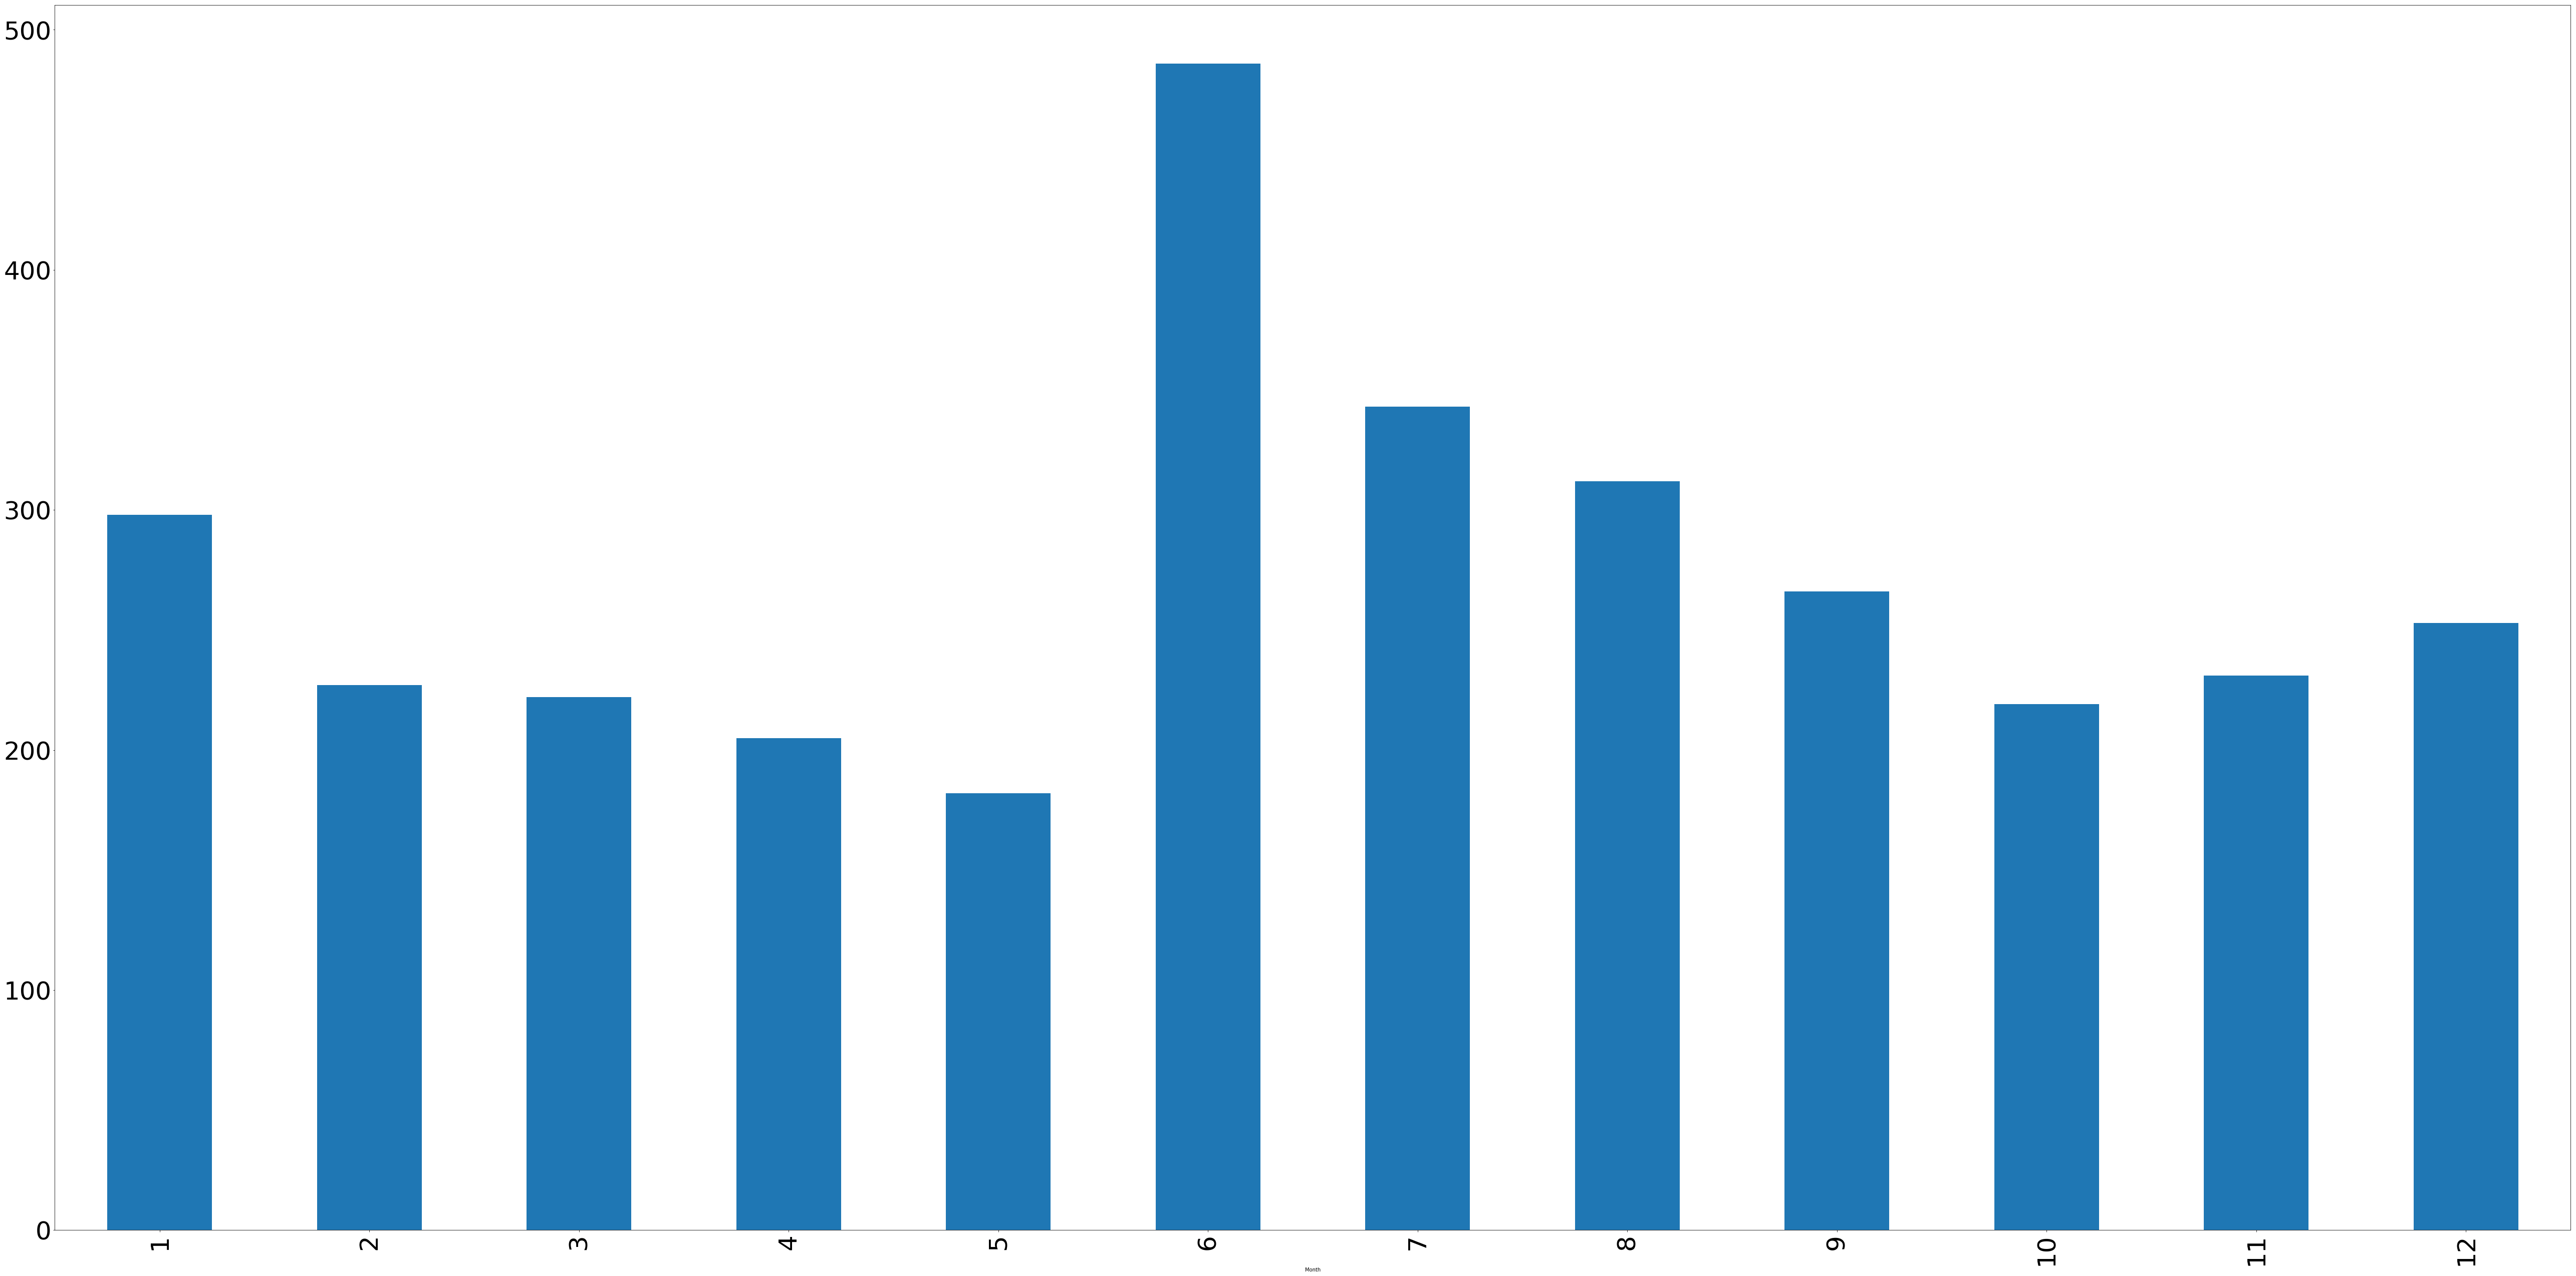

In [30]:
ataque_mes = datos_siglo.groupby(['Month']).size()
ataque_mes.plot(kind = 'bar', title = '', figsize = (90, 45), fontsize = 50)

In [31]:
meses_ataques_decada = datos_siglo.groupby([ 'Month', 'Decade']).size().sort_values( ascending = False)
print(meses_ataques_decada)

Month  Decade 
6      Años 50    84
1      Años 60    75
7      Años 90    74
6      Años 40    71
8      Años 90    71
6      Años 90    70
       Años 60    66
9      Años 90    63
7      Años 50    60
8      Años 60    50
10     Años 90    50
8      Años 50    49
7      Años 80    47
12     Años 60    46
6      Años 80    45
11     Años 90    45
12     Años 50    45
10     Años 80    42
1      Años 90    42
2      Años 60    41
6      Años 30    41
3      Años 90    41
6      Años 70    40
9      Años 80    38
7      Años 60    38
5      Años 90    38
4      Años 50    37
9      Años 60    37
2      Años 80    36
4      Años 60    35
                  ..
10     Años 20    14
7      Años 20    14
11     Años 10    14
       Años 30    14
8      Años 00    13
10     Años 30    13
       Años 40    13
4      Años 40    13
       Años 30    13
9      Años 00    12
       Años 10    12
10     Años 00    12
5      Años 70    12
9      Años 20    12
5      Años 20    11
       Años 10    1

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f21f128d0>],
      dtype=object)

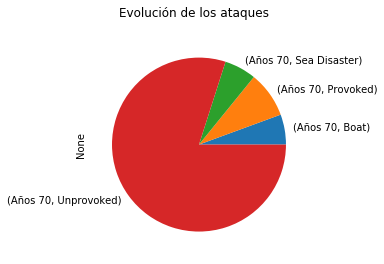

In [32]:
temp = datos_siglo[(datos_siglo.Decade == 'Años 70')]
typos = temp.groupby(['Decade', 'Type']).size()
typos.plot.pie(subplots=True, title = 'Evolución de los ataques')

Los ataques han ido en aumento a lo largo del siglo pasado, esto puede deberse a varios factores
